#### SSIM (Structural Similarity Index Measure)
- 각 이미지를 x,y라 할때 SSIM 식은 아래와 같음
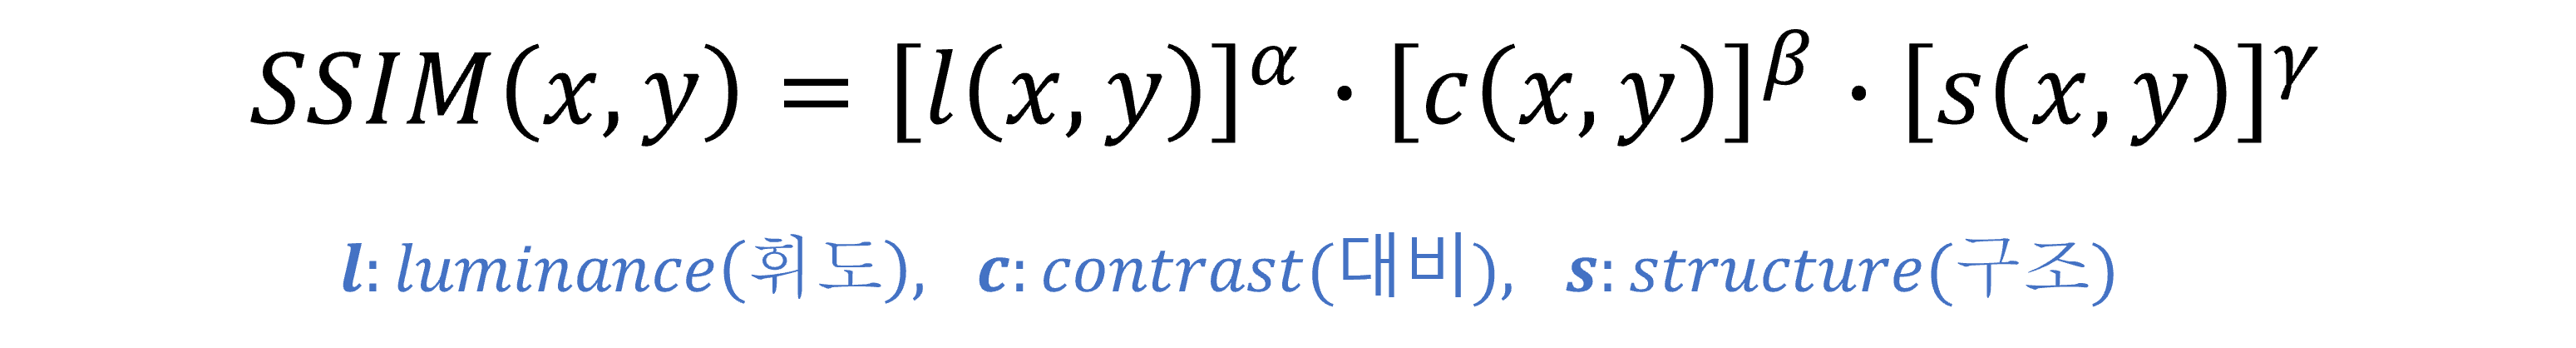
<font size="4">휘도는 빛의 밝기, 대비는 밝기 차이, 구조는 상관관계를 나타냄<font>
- 이미지 내 픽셀의 평균, 표준편차, 공분산을 이용하여 휘도, 대비, 구조를 계산할 수 있음
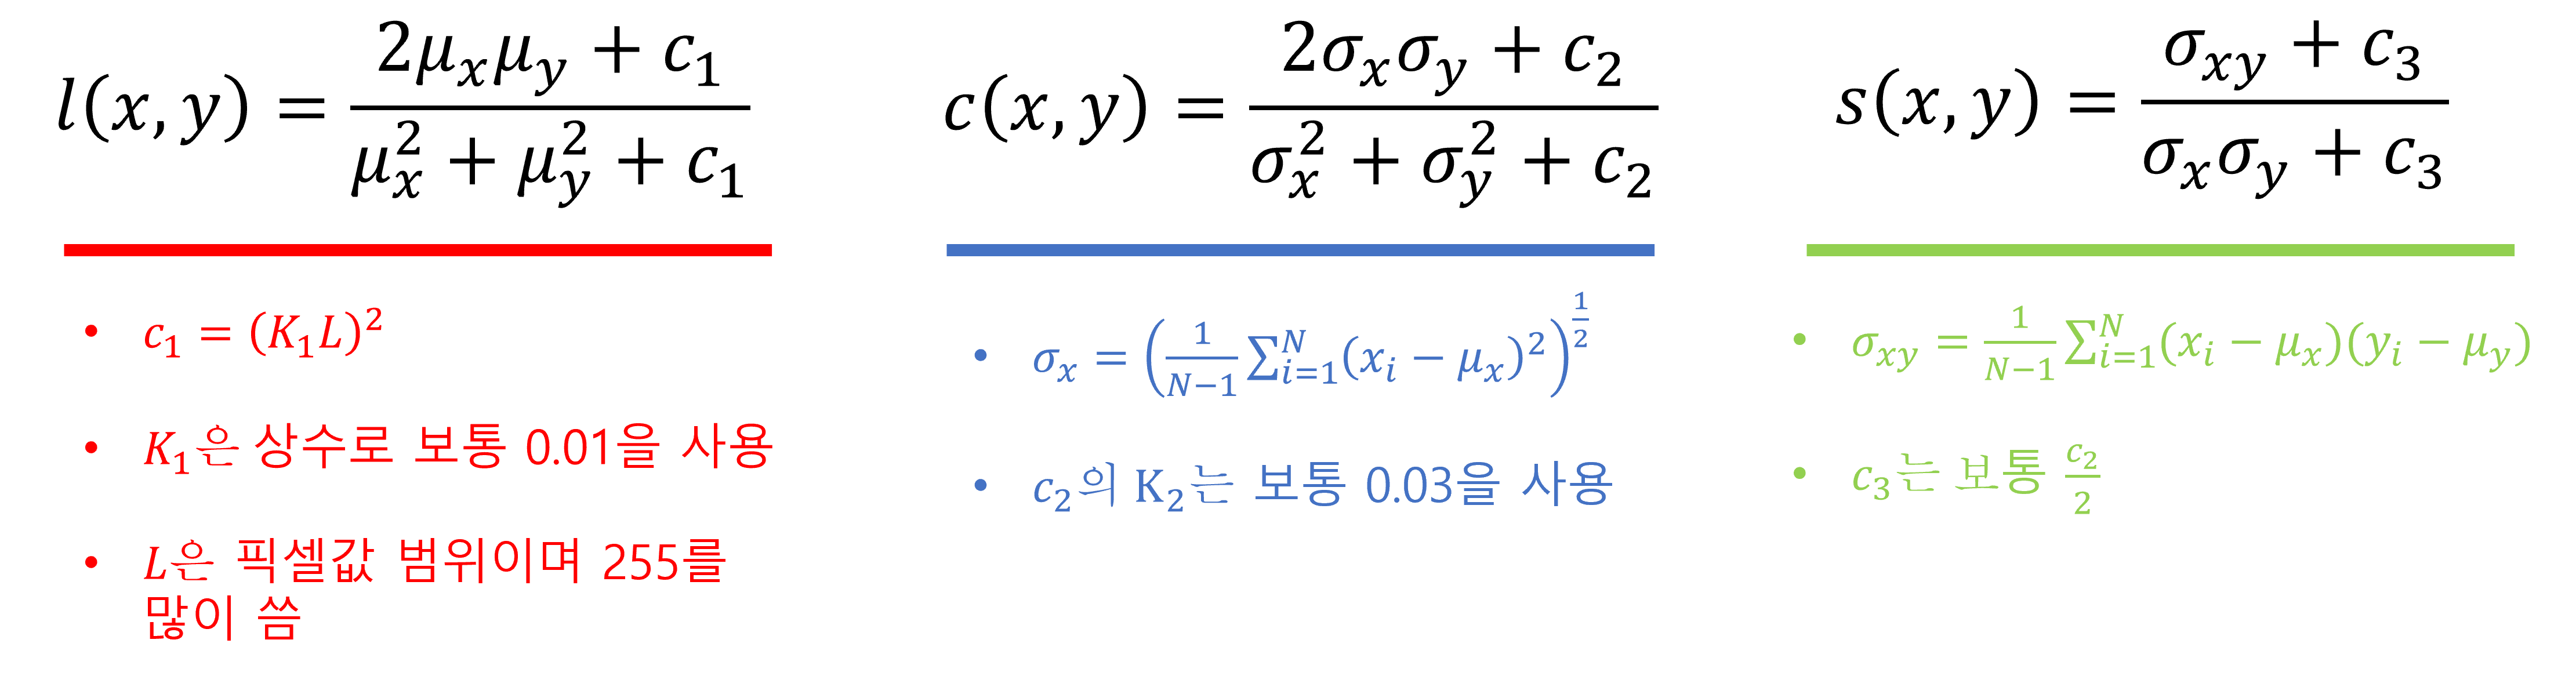

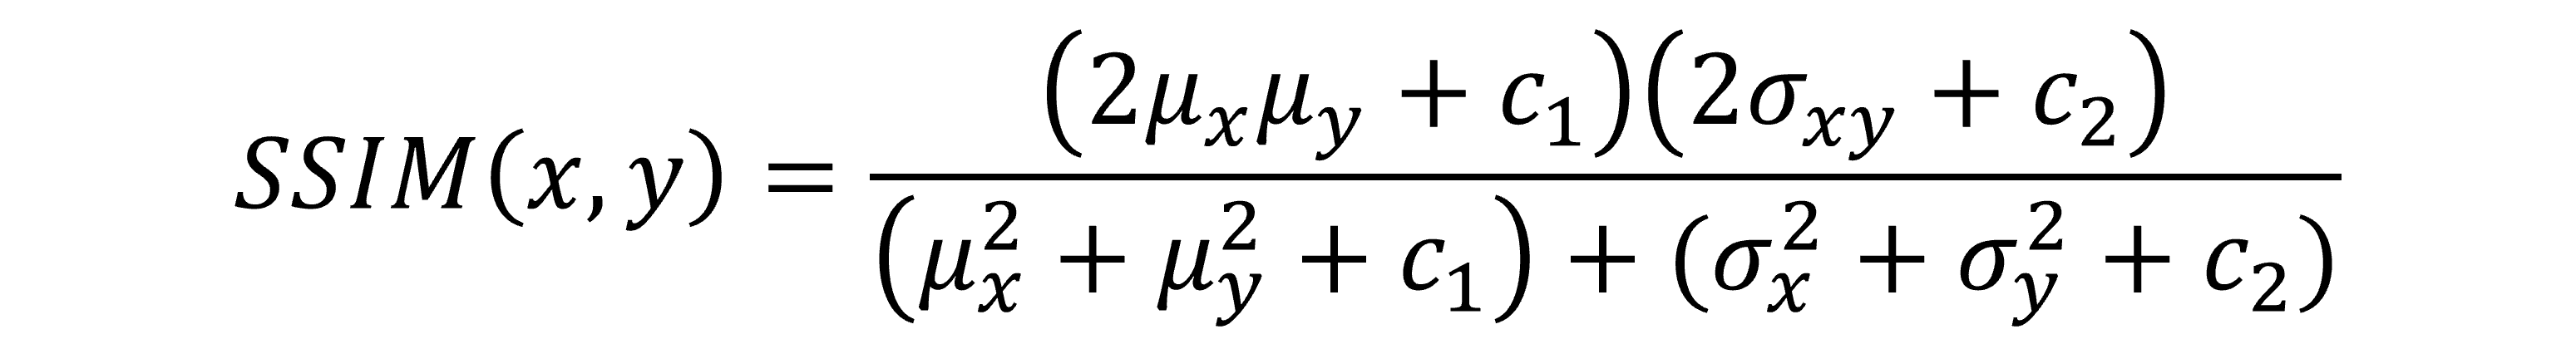

- SSIM을 Loss로 사용하려면 1-SSIM(x,y)를 사용하면 됨

<font size="4"> SSIM은 미분 가능하기에 loss로 사용 가능<font>

<font size="4"> 0~1사이의 값을 1에서 빼줌으로 유사도가 낮을 수록 값이 커지기에 loss로 사용 가능<font>

#### 사용해보기

In [7]:
import math
import torch
import os
import numpy as np
import cv2
import torchvision.transforms.functional as TF
from torchvision.io import read_image, ImageReadMode
from torchvision import transforms
from PIL import Image
from model import LPIENet

def ssim(img, img_blur):
    c1 = (0.01 * 255)**2
    c2 = (0.03 * 255)**2

    img = img.astype(np.float64)
    img_blur = img_blur.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img_blur, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img_blur**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img * img_blur, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + c1) * (2 * sigma12 + c2)) / ((mu1_sq + mu2_sq + c1) *
                                                            (sigma1_sq + sigma2_sq + c2))
    return ssim_map.mean()

In [5]:
def calculate_ssim(img, img_blur):

    if not img.shape == img_blur.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img.ndim == 2:
        return ssim(img, img_blur)
    elif img.ndim == 3:
        if img.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img, img_blur))
            return np.array(ssims).mean()
        elif img.shape[2] == 1:
            return ssim(np.squeeze(img), np.squeeze(img_blur))
    else:
        raise ValueError('Wrong input image dimensions.')

In [8]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.CenterCrop((540,960)),
    transforms.ToTensor(),
])

model = LPIENet(3, 3, [16, 32, 64], [32, 16])
model.load_state_dict(torch.load('best.pth'))
model.to(device)
img_blur = read_image('img_blur.png', mode = ImageReadMode.RGB)
img_blur = transform(img_blur).to(device)

result = model(img_blur.unsqueeze(0))
p = 1e-5
result = result.clip(0, 1 - p) # 이상치 값 clip


# result를 png이미지로 변경
result_image = TF.to_pil_image(result.squeeze().cpu())
print(result_image)
result_image.save('result_image.png')

<PIL.Image.Image image mode=RGB size=960x540 at 0x23F070AFF48>


In [12]:
img = cv2.imread('img.png')
img = cv2.resize(img, (960, 540))

img_blur = cv2.imread('img_blur.png')
img_blur = cv2.resize(img_blur, (960, 540))

value = calculate_ssim(img, img_blur)
print(f"Before SSIM value is {value}")


img = cv2.imread('img.png')
# 이미지 크기 가져오기
height, width = img.shape[:2]
# 새로운 이미지 크기 설정
new_width, new_height = 960, 540

# 결과 이미지가 center_crop된 이미지이므로, 이미지를 Center Crop하여 리사이즈
left = (width - new_width) // 2
top = (height - new_height) // 2
cropped_img = img[top:top + new_height, left:left + new_width]

result_image = cv2.imread('result_image.png')
value = calculate_ssim(cropped_img, result_image)
print(f"After SSIM value is {value}")

Before SSIM value is 0.7195618732441865
After SSIM value is 0.7893639692371669
